Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
(16299195, 4)
(16299, 4)
cuda:0
16299


OSError: Unable to load weights from pytorch checkpoint file for bertat '/home/xiaoguzai/模型/toxic-comment second pretrain sequence/labeled_data+model_epoch=175.pth'If you tried to load a PyTorch model from a TF 2.0 checkpoint, please set from_tf=True. 

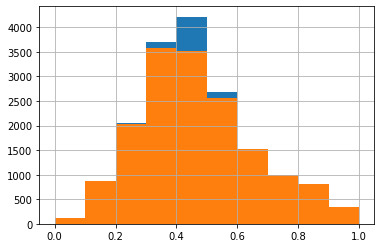

In [1]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment second pretrain sequence/labeled_data+model_epoch=175.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

In [ ]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment second pretrain sequence/labeled_data+model_epoch=175.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth'))
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')

In [ ]:
import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,import torch
import numpy as np
import random
import os
random_seed = 1
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit-pair/ruddit_pairs.csv")  # create a dateframe based on a file

print(df_.shape) 

df_ = df_.sample(frac=frac_1,random_state=random_seed).sample(frac=1,random_state=random_seed)
print(df_.shape)

df_1 = df_[['txt1','sc1']].rename(columns={'txt1':'txt','sc1':'y'})
df_2 = df_[['txt2','sc2']].rename(columns={'txt2':'txt','sc2':'y'})

min_data = min(df_1.y.min(),df_2.y.min())
max_data = max(df_2.y.max(),df_2.y.max())
df_1['y'] = (df_1['y']-min_data)/(max_data-min_data)
df_2['y'] = (df_2['y']-min_data)/(max_data-min_data)

df_1.y.hist()
df_2.y.hist()

import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/数据/kaggle有毒评论对比/roberta-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
import torch.nn as nn
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        output = self.model(input_ids)
        output = self.dropout(output)
        output = output[:,0]
        output = self.dropout(output)
        output = self.fc(output)
        return output

def train_compute_multilabel_loss(x1,x2,model,label1,label2):
    logit1 = model(x1)
    logit2 = model(x2)
    logitmargin = logit1-logit2
    labelmargin = label1-label2
    loss_fn = torch.nn.MSELoss(reduce=True, size_average=True)
    marginloss = loss_fn(logitmargin,labelmargin)
    return marginloss

#tokenizer = FullTokenizer(vocab_file=vocab_file)
from torch.utils.data import Dataset,DataLoader
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
class ClassificationDataset(Dataset):
    def __init__(self,text1,text2,maxlen,label1,label2):
        self.text1 = text1
        self.text2 = text2
        self.maxlen = maxlen
        self.label1 = label1
        self.label2 = label2
        token_id1,token_id2 = [],[]
        for index in tqdm(range(len(self.text1))):
            current_text1 = text1[index]
            current_id = tokenizer(current_text1)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id1.append(current_id)
            current_text2 = text2[index]
            current_id = tokenizer(current_text2)['input_ids']
            current_id = self.sequence_padding(current_id)
            token_id2.append(current_id)
        self.tensors = [torch.tensor(token_id1),torch.tensor(token_id2),\
                        torch.tensor(label1),torch.tensor(label2)]
        
    def __len__(self):
        return len(self.label1)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = 1):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
#易错点：testdataset的内容需要跟classificationdataset的内容保持一致
class TestDataset(Dataset):
    def __init__(self,text,maxlen):
        self.text = text
        self.maxlen = maxlen
        token_id = []
        for index in tqdm(range(len(self.text))):
            current_text = text[index]
            current_id = tokenizer(current_text)['input_ids']
            #roberta begin:0,end:2
            #current_id = tokenizer.convert_tokens_to_ids(current_token)
            current_id = self.sequence_padding(current_id)
            token_id.append(current_id)
        self.token_id = token_id
        
    def __len__(self):
        return len(self.token_id)

    def __getitem__(self,index):
        #return [tuple(tensor[index] for tensor in self.tensors)]
        return self.token_id[index]
    
    def sequence_padding(self,inputs,padding=1):
        #英文roberta padding=1
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x
    
valid_data_df = pd.read_csv("/home/xiaoguzai/数据/Kaggle Jigsaw Rate Severity of Toxic Comments/validation_true.csv")

from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
bestpoint = []
n_folds = 6
#先单模单折

r"""
比较l1loss和mseloss的不同结果
比较9e-6和2e-5的学习率
"""

less_toxic,more_toxic = valid_data_df['less_toxic'].values.tolist(),valid_data_df['more_toxic'].values.tolist()
#print('less_toxic = ')
#print(less_toxic[0:10])
#print('more_toxic = ')
#print(more_toxic[0:10])
for current_slit in range(n_folds):
    bestpoint.append(0.0)
    
from loader_pretrain_weights import load_pretrain_data
for current_split in range(1):
    train_text1,train_text2,train_label1,train_label2 = [],[],[],[]
    #单模单折所有数据作为训练集
    #下面部分数据可能加入了
    train_text1 = train_text1+df_1['txt'].values.tolist()
    train_text2 = train_text2+df_2['txt'].values.tolist()
    train_label1 = train_label1+df_1['y'].values.tolist()
    train_label2 = train_label2+df_2['y'].values.tolist()
    
    #加入ruddit_data进行训练
    print(len(train_text1))
    
    #def __init__(self,text,maxlen,labels)
    
    #加载官方bert模型
    Roberta,robertaconfig,get_data = get_model_function('roberta-base')
    config = robertaconfig(**json_data)
    config.with_mlm = False
    roberta = Roberta(config)
    roberta = load_pretrain_data(roberta,'/home/xiaoguzai/模型/toxic-comment second pretrain sequence/labeled_data+model_epoch=185.pth')
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth'))
    model = ClassificationModel(roberta,config,1)
    
    train_dataset = ClassificationDataset(text1=train_text1,text2=train_text2,\
                                          maxlen=500,label1=train_label1,label2=train_label2)
    train_loader = DataLoader(train_dataset,batch_size=4,shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
    def lr_lambda(epoch):
        if epoch > 5:
            return 1
        else:
            return 2/(epoch+1)
    scheduler = LambdaLR(optimizer, lr_lambda)
    print("初始化的学习率：", optimizer.defaults['lr'])
    
    for epoch in range(4):
        print('epoch {}'.format(epoch))
        
        train_loss = 0
        train_acc = 0
        #model = torch.load('/home/xiaoguzai/程序/kaggle有毒评论对比比赛/best_score=20261.0split=0.pth')
        
        model.train()

        model = model.to(device)
        model = nn.DataParallel(model)
        loss_fn = torch.nn.L1Loss(reduce=True,size_average=True)
        

        for batch_token_id1,batch_token_id2,batch_label1,batch_label2 in tqdm(train_loader):
            torch.set_printoptions(edgeitems=768)# 设置输出矩阵维度为768
            batch_token_id1 = batch_token_id1.to(device)
            batch_token_id2 = batch_token_id2.to(device)
            batch_label1 = batch_label1.to(device)
            batch_label2 = batch_label2.to(device)
            optimizer.zero_grad()
            loss = train_compute_multilabel_loss(batch_token_id1,batch_token_id2,model,batch_label1,batch_label2)
            train_loss = train_loss+loss
            loss.backward()
            optimizer.step()
        scheduler.step()
        print("第%d个epoch的学习率：%f" % (epoch, optimizer.param_groups[0]['lr']))
        #注意必须从epoch=1开始，否则第0个没有学习率
        print('Train Loss: {:.6f}'.format(train_loss))
        
        less_toxic_point,more_toxic_point = [],[]
        right = []
        test_dataset = TestDataset(less_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        model.eval()
        model = model.to(device)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                less_toxic_point = less_toxic_point+result_point.cpu().numpy().tolist()
        test_dataset = TestDataset(more_toxic,maxlen=500)
        test_loader = DataLoader(test_dataset,batch_size=16)
        for batch_token in tqdm(test_loader):
            batch_token = batch_token.to(device)
            with torch.no_grad():
                result_point = model(batch_token)
                more_toxic_point = more_toxic_point+result_point.cpu().numpy().tolist()
        right_point = sum([less_toxic_point[index] < more_toxic_point[index] for index in range(len(less_toxic_point))])
        right_point = right_point/len(less_toxic_point)
        print('right_point = ')
        print(right_point)
        if right_point >= bestpoint[current_split]:
            bestpoint[current_split] = right_point
            torch.save(model,'./best_score='+str(bestpoint[current_split])+'seed='+str(random_seed)+'.pth')